In [4]:
%load_ext autoreload
%autoreload 2

In [2]:
from ToyTrajectoryNet.utils import generate_steps, set_seeds, config_criterion
from ToyTrajectoryNet.models import make_model, Autoencoder
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train_ae, training_regimen
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from ToyTrajectoryNet.geo import setup_distance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [3]:
data = np.load('../data/eb_v4_df_pca200.npy', allow_pickle=True)

In [3]:
sample_labels = data[:,-1]
sample_labels=sample_labels.astype(np.int32) 
sample_labels[sample_labels==4] = 3
embedding = data[:,:-1].astype(np.float32) 
df = pd.DataFrame(embedding, columns=[f'd{i}' for i in range(1, 201)])
df['samples'] = sample_labels.astype(np.int32)  
#del data, embedding, sample_labels
df = df.sample(n=20000,random_state=1,axis=0)

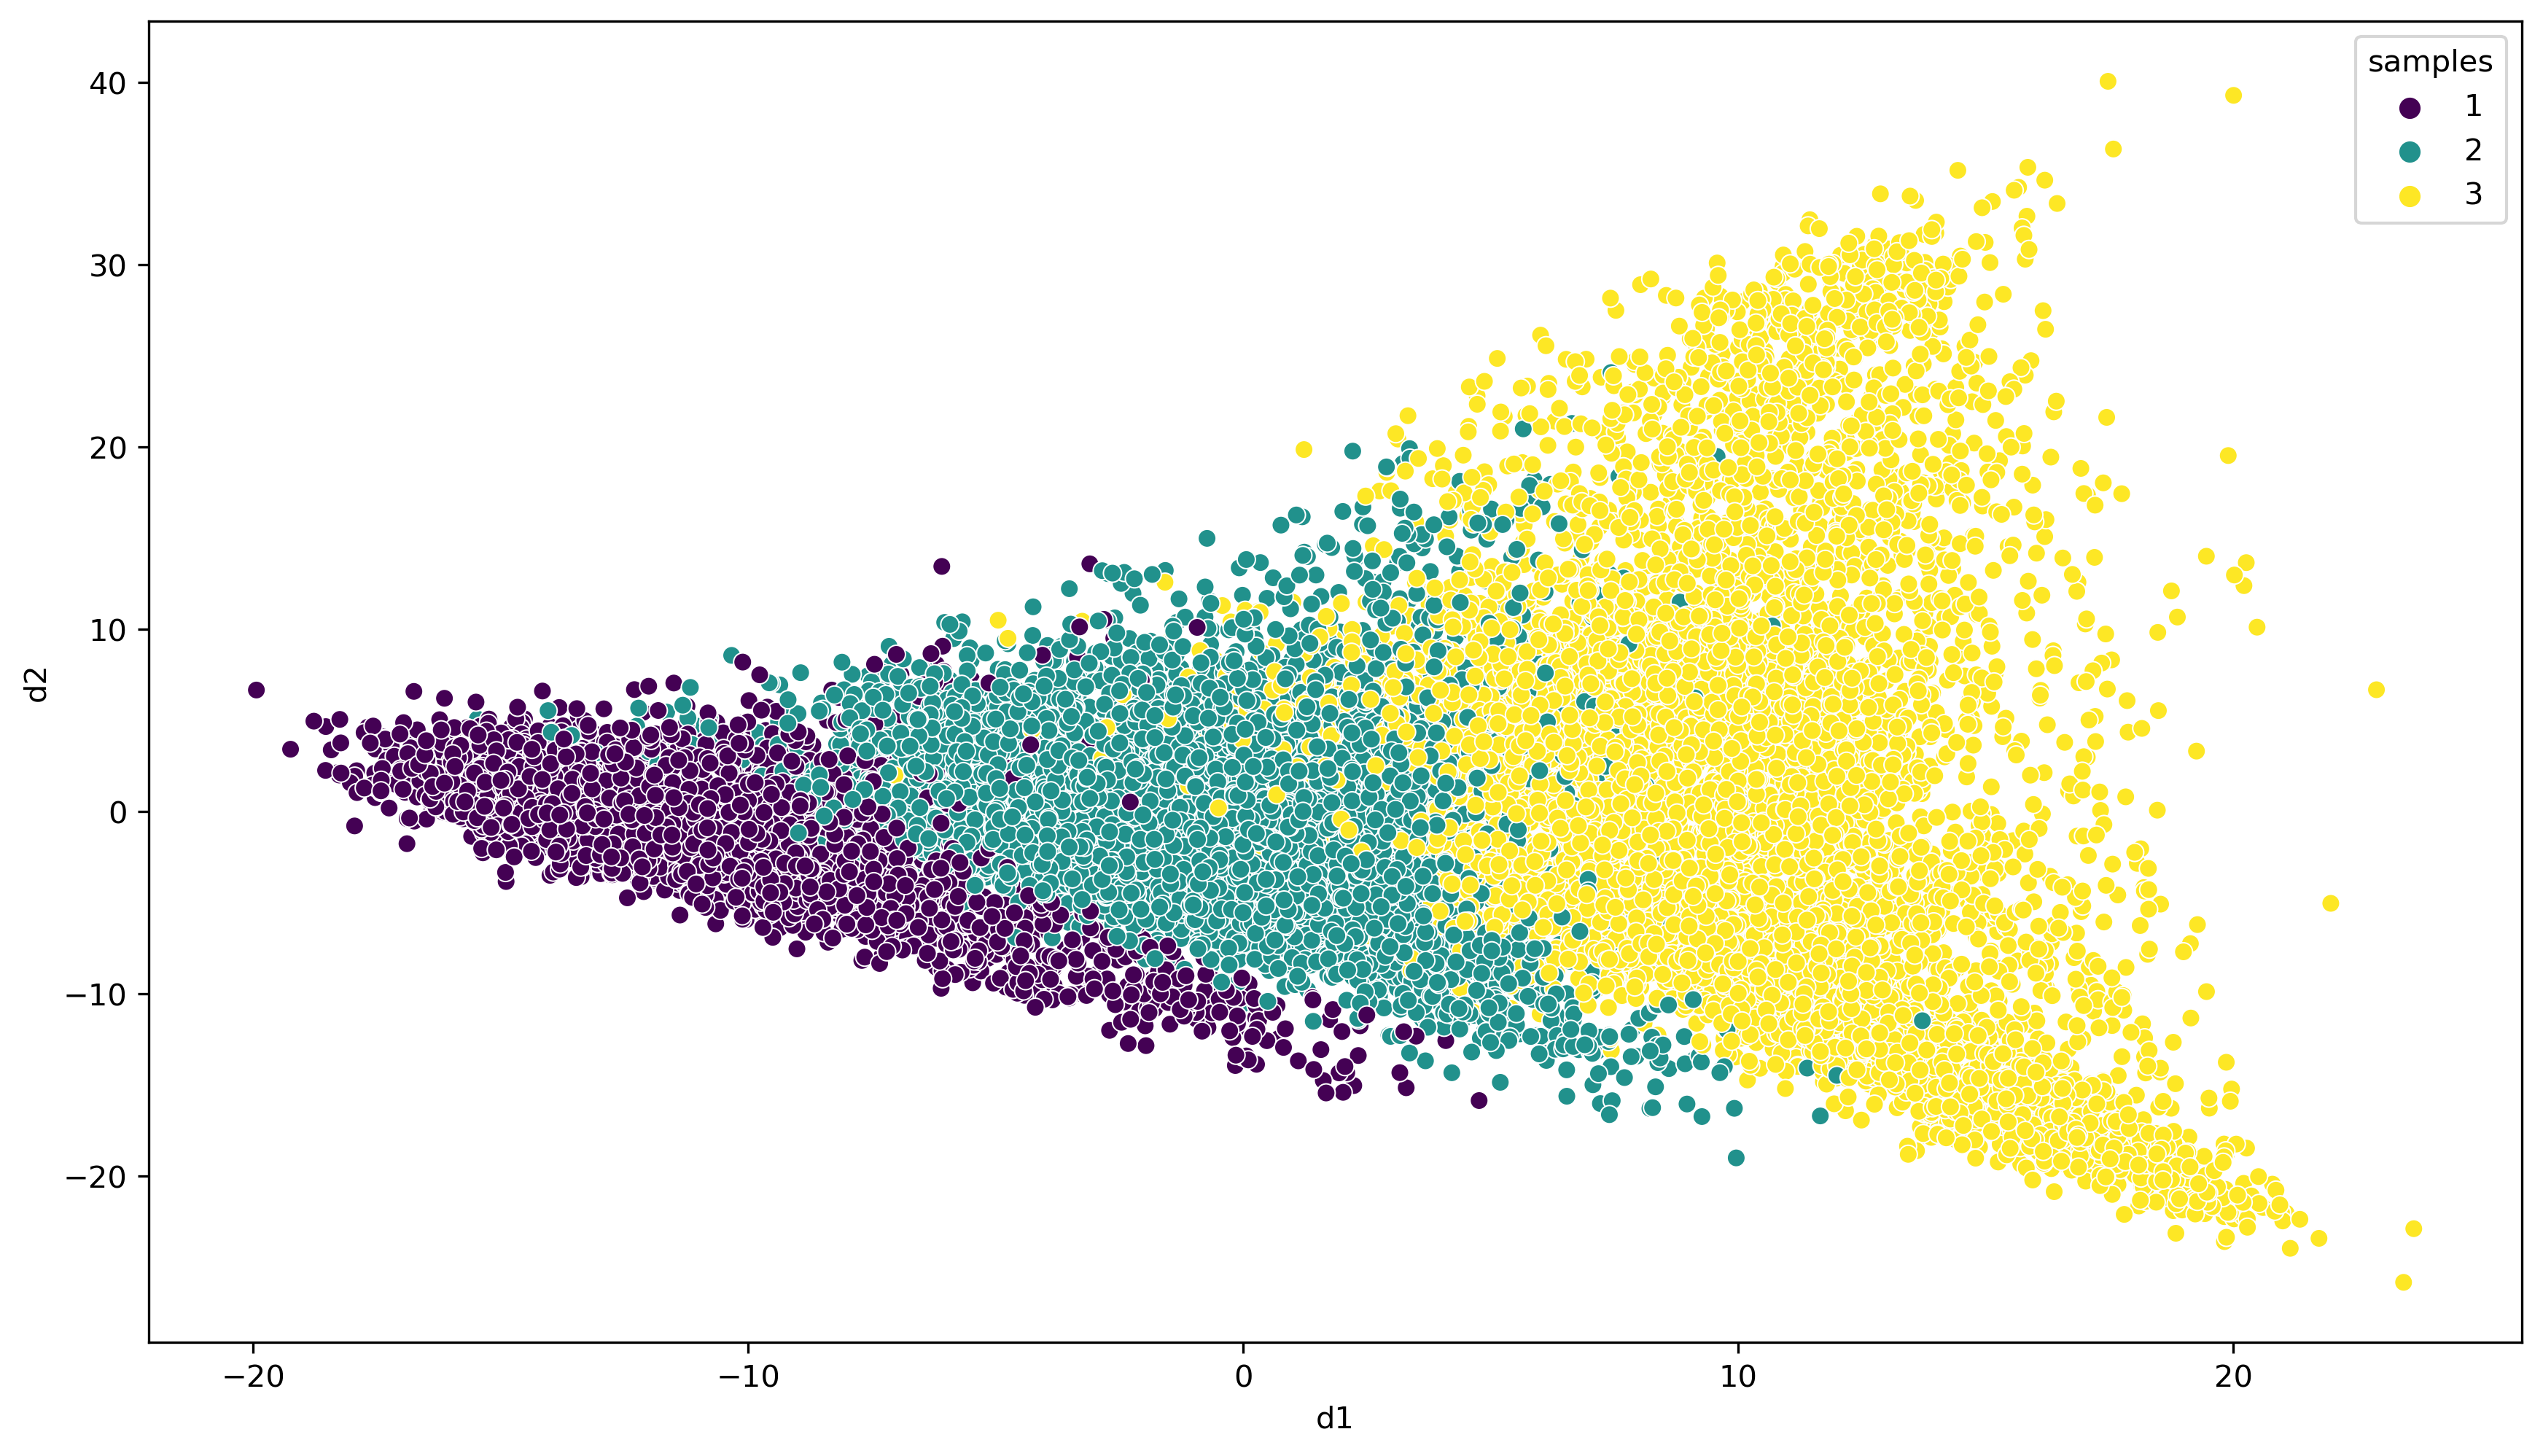

In [4]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [290]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [291]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = True
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [292]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = True

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'alpha_decay'
rbf_length_scale=0.001
knn=5
t_max=5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale, knn=knn, t_max=t_max)

#Can be changed depending on the dataset
n_epochs_emb = 1500
samples_size_emb = (50, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 50
encoder_layers = [model_features, 100, 100, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [293]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

  0%|          | 0/1500 [00:00<?, ?it/s]

Train loss recon: 2.69767
Train loss dist: 16.48658
Train loss recon: 2.31228
Train loss dist: 2.28906
Train loss recon: 2.25113
Train loss dist: 1.39765
Train loss recon: 2.09854
Train loss dist: 1.31571
Train loss recon: 1.84265
Train loss dist: 1.17986
Train loss recon: 1.83932
Train loss dist: 1.15267
Train loss recon: 1.86414
Train loss dist: 0.94
Train loss recon: 1.65973
Train loss dist: 1.03595
Train loss recon: 1.57827
Train loss dist: 0.90125
Train loss recon: 1.64243
Train loss dist: 0.76762
Train loss recon: 1.66485
Train loss dist: 0.85427
Train loss recon: 1.49482
Train loss dist: 0.78781
Train loss recon: 1.46507
Train loss dist: 0.75201
Train loss recon: 1.50645
Train loss dist: 0.76827
Train loss recon: 1.56166
Train loss dist: 0.6741
Train loss recon: 1.35733
Train loss dist: 0.71614
Train loss recon: 1.43554
Train loss dist: 0.66128
Train loss recon: 1.47368
Train loss dist: 0.66024
Train loss recon: 1.41427
Train loss dist: 0.64098
Train loss recon: 1.47974
Train lo

# Specify parameters

In [294]:
set_seeds(10)

#Directory where results are saved
exp_name = 'holdout_eb'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 20

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda
)

In [295]:
# Basically "batch size"
sample_size=(100, )

# Training specification
n_local_epochs = 40
n_epochs = 40
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    groups_ho = [g for g in groups if g != hold_out]
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups_ho)}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 1000
n_trajectories = 100
n_bins = 100


In [296]:
opts = {
    'pca_dims': 200,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n,
    'knn': knn,
    't_max': t_max
}

In [297]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [1]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

NameError: name 'time' is not defined

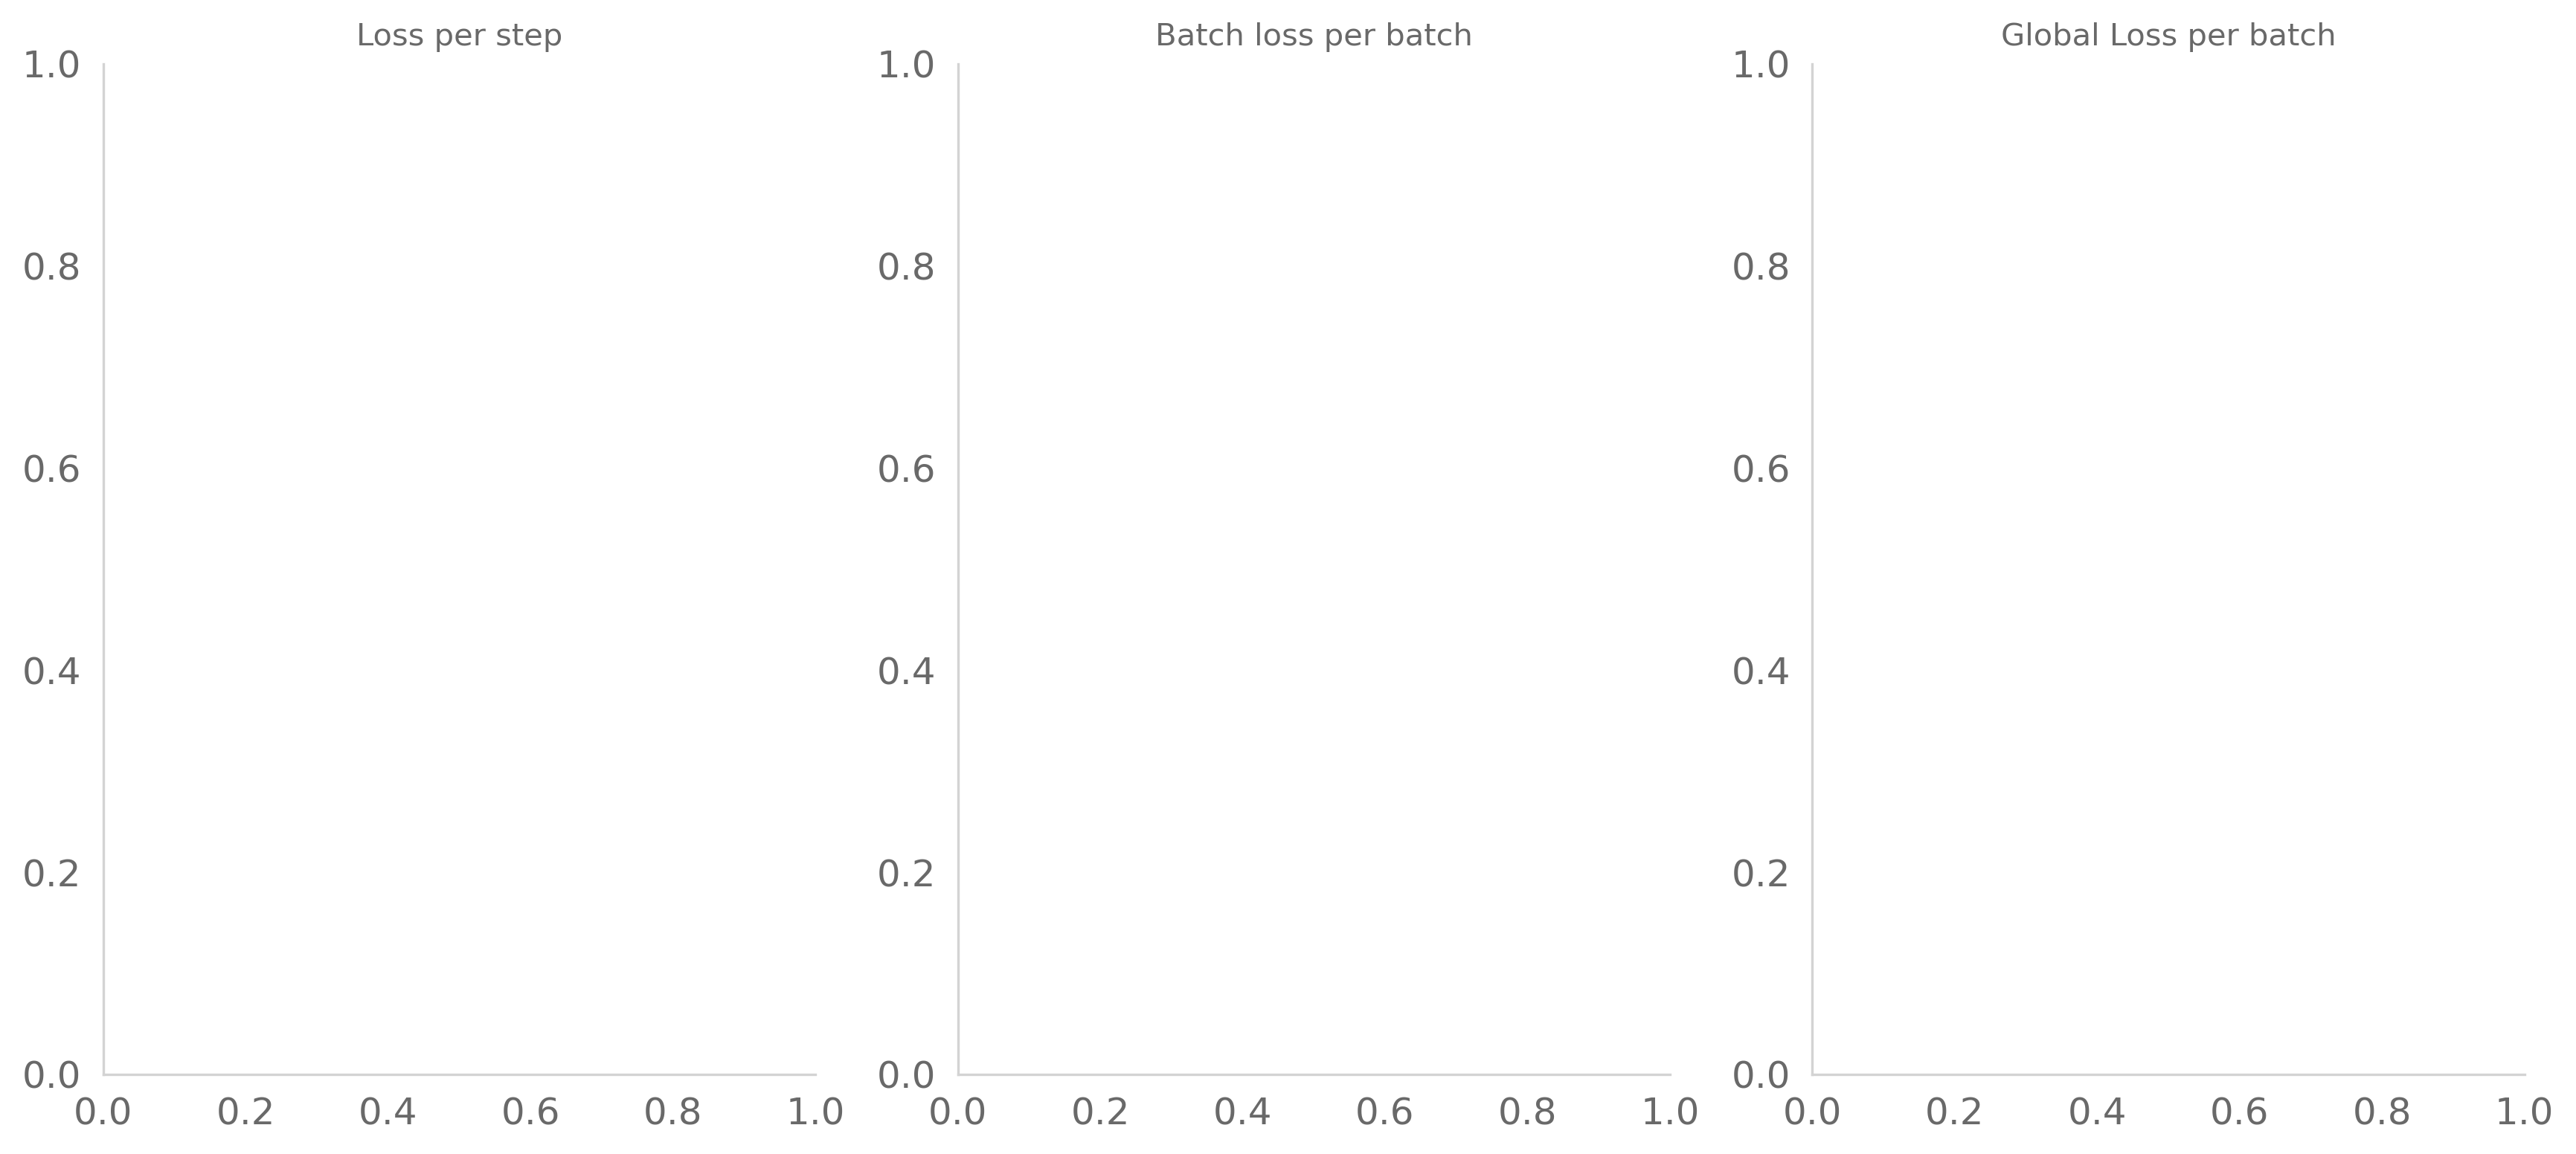

In [ ]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [299]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

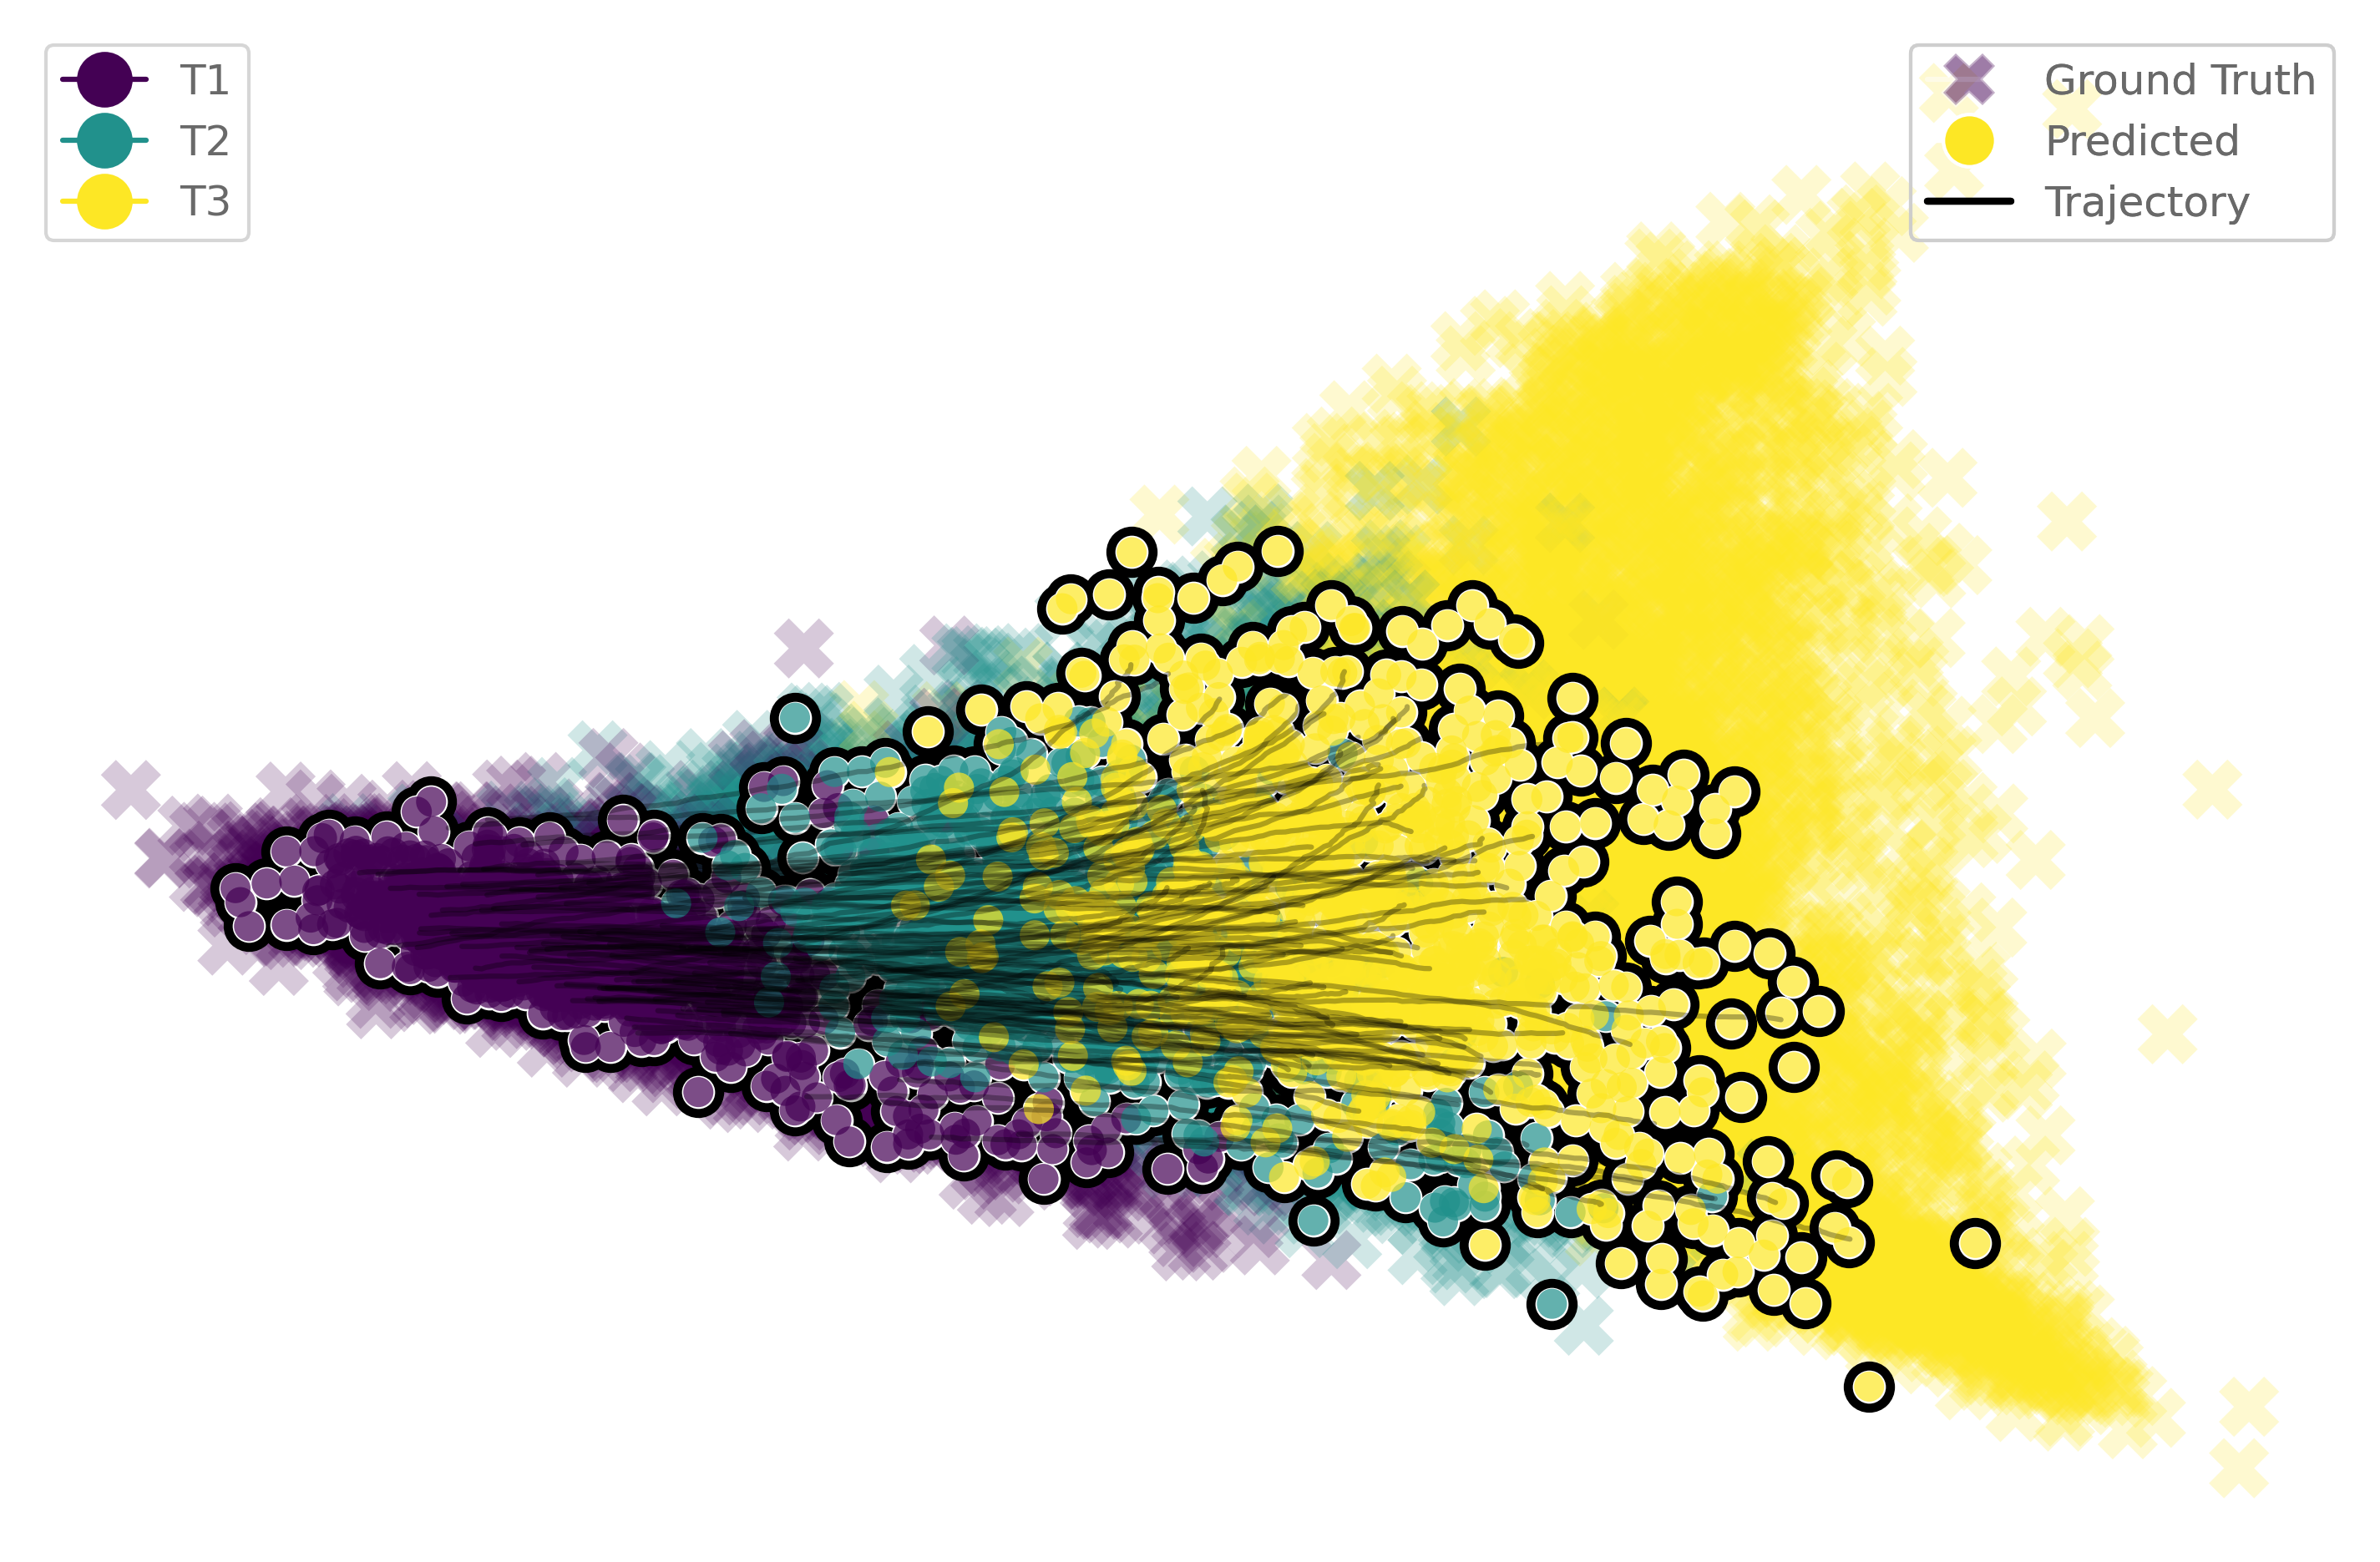

In [300]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

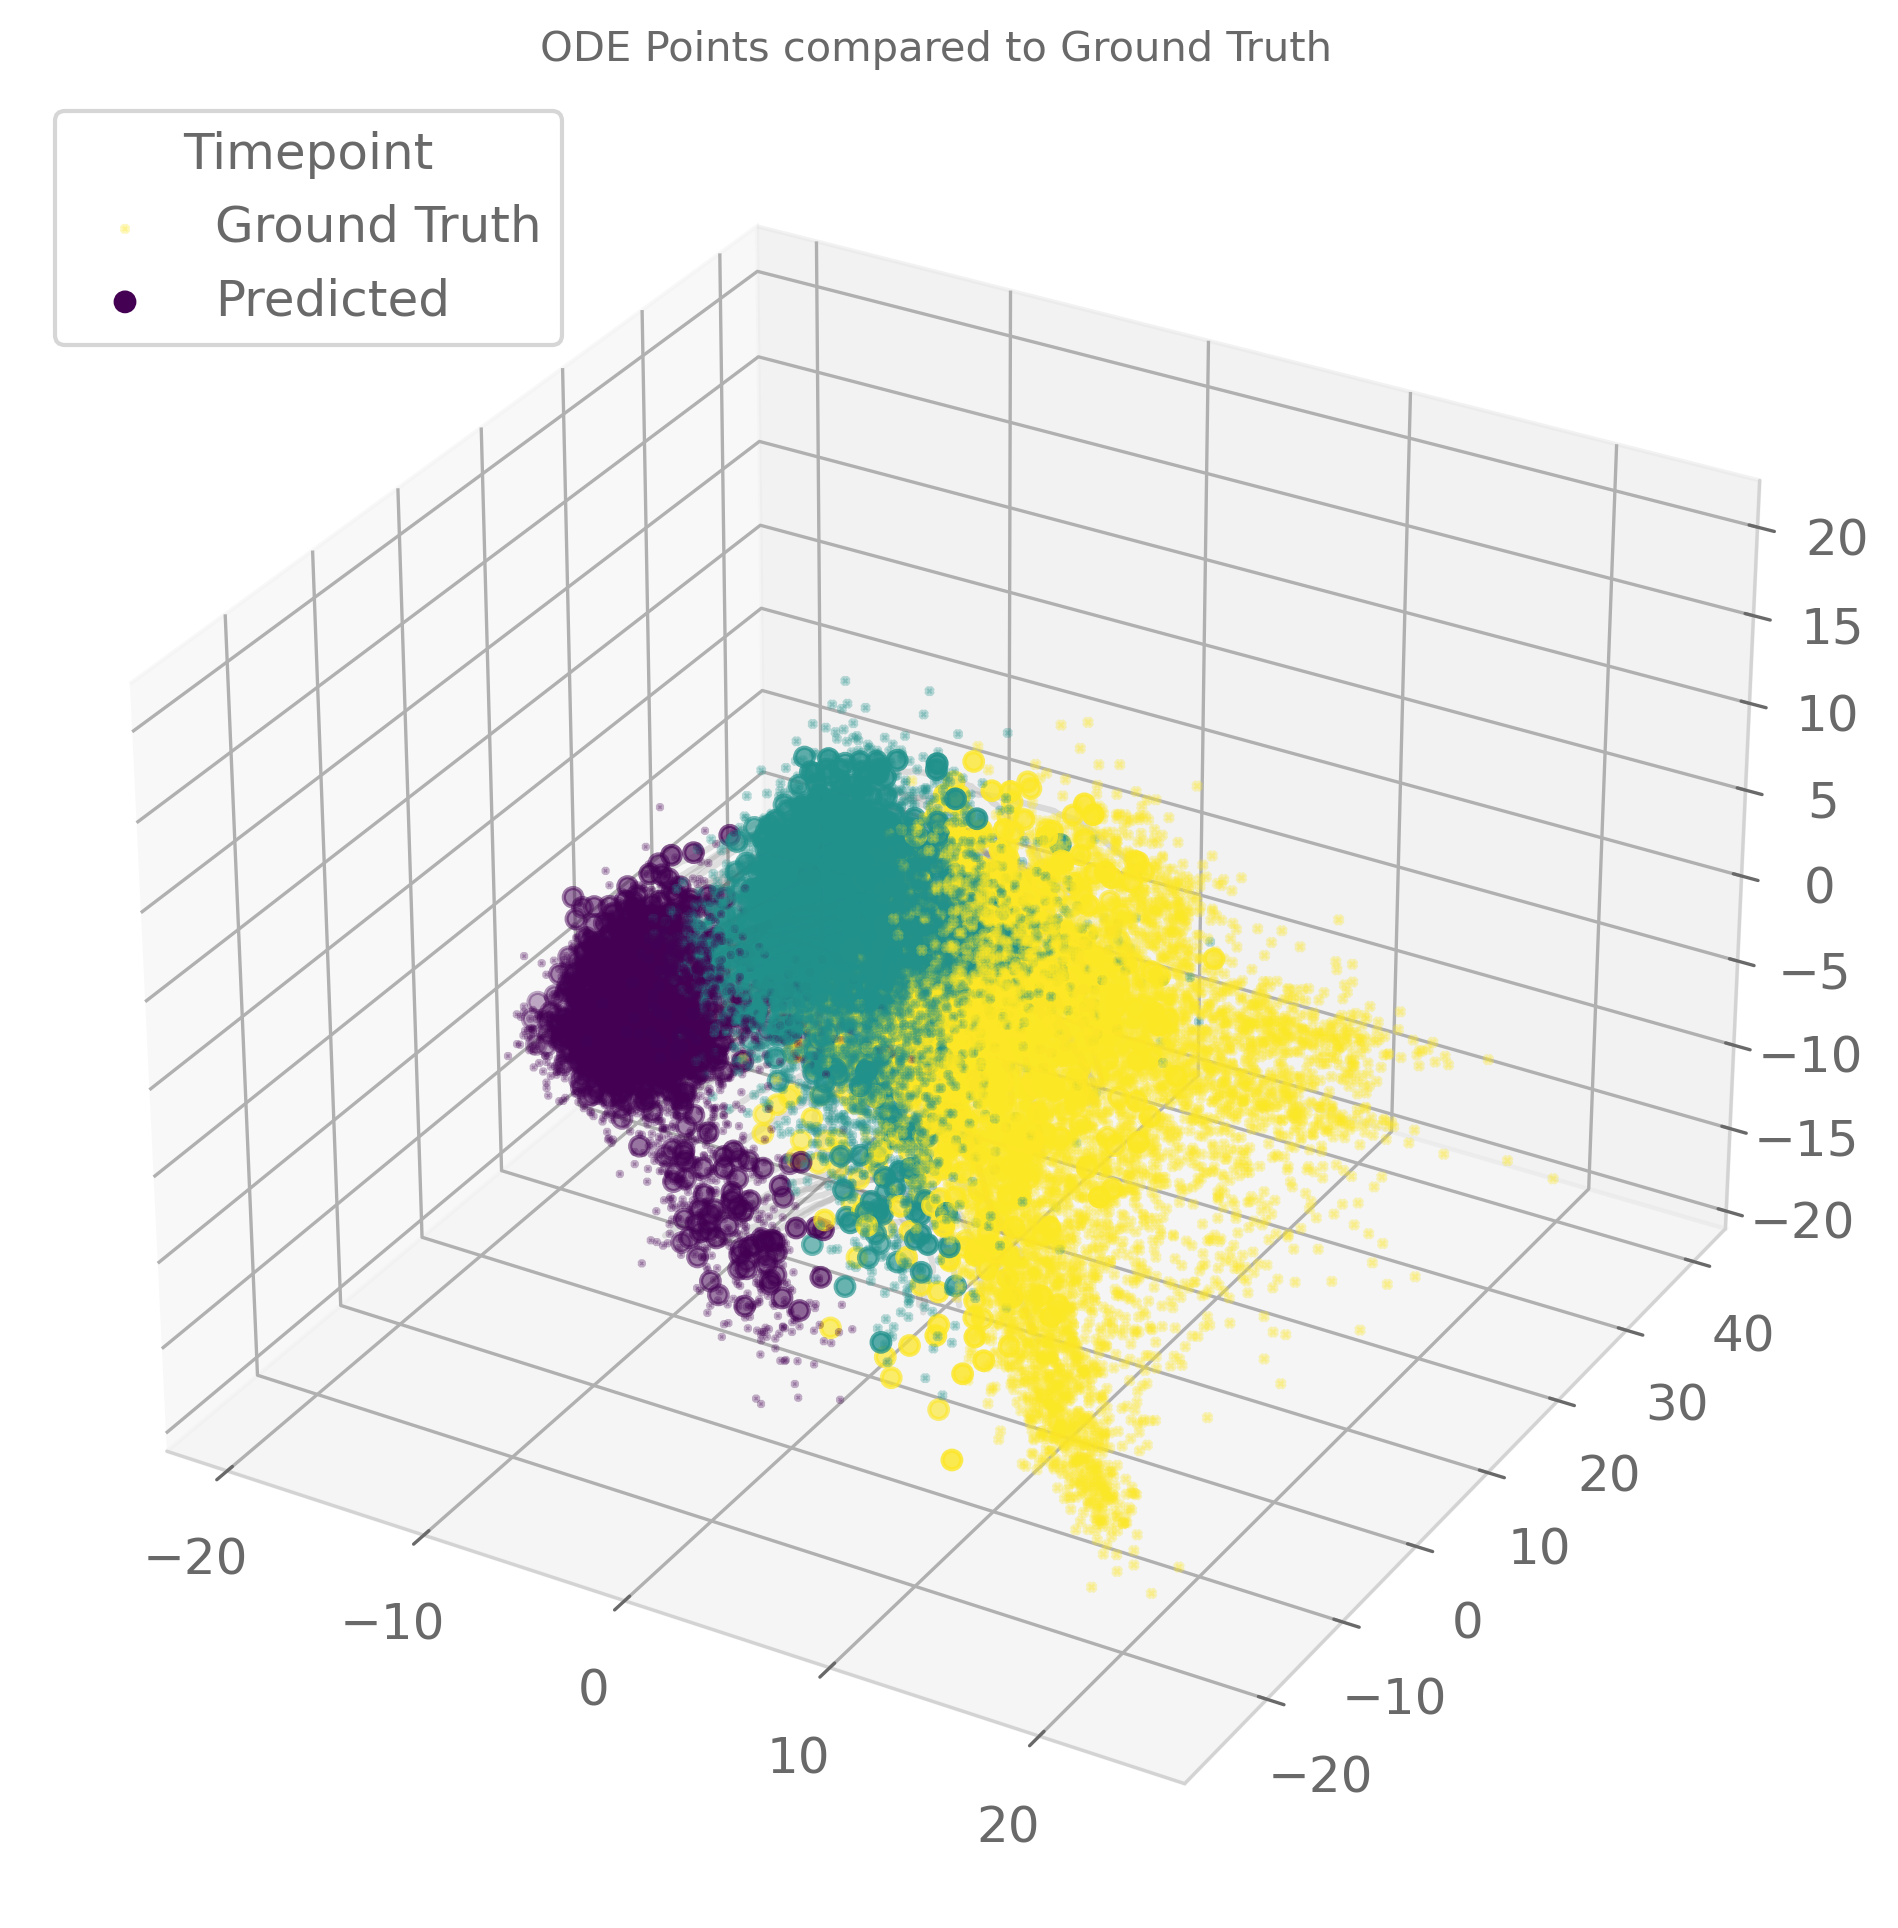

In [112]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='3d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=True
)

In [236]:
# saving the trajectories and generated points
np.save(os.path.join(exp_dir,'trajectories_leave{}_noemb.npy'.format(hold_out)),trajectories)
np.save(os.path.join(exp_dir,'generated_leave{}_noemb.npy'.format(hold_out)),generated)

In [ ]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [ ]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [301]:
#gen = np.load('///')
from ToyTrajectoryNet.utils import group_extract, sample
import ot
from ToyTrajectoryNet.losses import MMD_loss
set_seeds(10)
xs = generated[2]
xt = sample(df,group=3,size=1000)
xs.shape,xt.shape
a = torch.tensor(ot.unif(xs.shape[0]))
b = torch.tensor(ot.unif(xt.shape[0]))
M = ot.dist(xs, xt, metric='euclidean')
print('EMD:',ot.emd2(a, b, M))
mmd = MMD_loss()
print('MMD:',mmd.forward(torch.tensor(xs),torch.tensor(xt)))

EMD: 33.12110272860256
MMD: tensor(0.7422)
